# MEng-Team-Project-ML

This notebook contains the initial analysis of SQLite DB files generated \
by our ML system as of February 2022 (refer to git commit for exact \
version).

Each one of our key objectives is far easier to implement than before because\
the StrongSORT algorithm is very performant, and easy to calibrate for our use\
case.
- Object Identification 
  - This objective is the easiest to implement as we have the predicted \
    class along with it's bounding box per frame.
- Object Count
  - For this objective, we just count the number of unique IDs across time. The \
    lower the IDs (identity switching) and higher the AssA (association accuracy) \
    of our model for our dataset, the more reliable this object count will be, and \
    less post-processing of the analytics will be required.
- Object Tracking
  - For each object which is being successfully tracked and ID'd, we track its \
    detected anchor point from its bounding box across time and see which \
    boundaries of the video footage it's intersecting with, to \
    see which routes it's going from and to.

## Load Dataset

### Load COCO Classes

In [1]:
COCO_CLASSES = [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]

### Load Pre-Saved Analytical Dataset (SQLite)

In [2]:
import os
from traffic_ml.lib.gdrive import get_gdrive_id, download_file_from_google_drive

TEST_FILE_FNAME = "tfl_snow.db"
TEST_FILE_LINK  = "https://drive.google.com/file/d/1c7TE4w39T-fEKqq8DbO8NCsK-N5c3MO5/view?usp=sharing"

gdrive_id = get_gdrive_id(TEST_FILE_LINK)
out = download_file_from_google_drive(gdrive_id, f"./{TEST_FILE_FNAME}")

if os.path.exists(TEST_FILE_FNAME):
    print("Downloaded successfully!")
else:
    print(f"Error downloading: {TEST_FILE_FNAME}")

Downloaded successfully!


## Data Analysis

### Load Data into Dataframes

In [11]:
import sqlite3
import pandas as pd

# NOTE: Overwrite this for a local analysis
TEST_FILE_FNAME = "00001.01350_2022-12-07T15-35-24.000Z.db"
con = sqlite3.connect(TEST_FILE_FNAME)

# Detected Objects per Frame
detections_df = pd.read_sql_query("SELECT * FROM detection;", con)

con.close()

### Detection Count (per Frame)

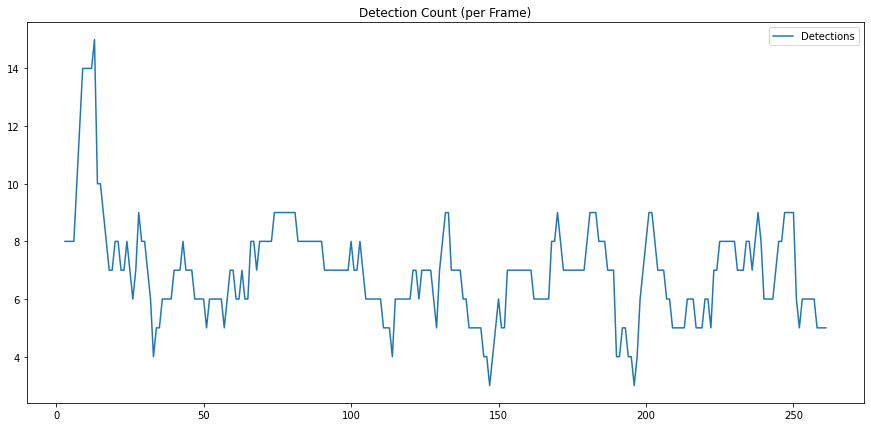

In [37]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,7)

det_count = detections_df["frame"].value_counts().sort_index()

plt.title("Detection Count (per Frame)")
plt.plot(det_count, label="Detections")

plt.legend()

### Object Count

In [55]:
data = detections_df

In [56]:
counts = data.groupby('label')['det_id'].nunique().reset_index(name='count')

In [57]:
counts

,label,count
0,bicycle,1
1,bus,3
2,car,10
3,person,21
4,truck,2


### Object Tracking

In [90]:
routes_df = data[["frame", "label", "det_id", "bbox_x", "bbox_y", "bbox_w", "bbox_h"]].copy()
routes_df["anchor_x"] = routes_df.apply(
    lambda row: row["bbox_x"] + (row["bbox_w"] / 2.0), axis=1)
routes_df["anchor_y"] = routes_df.apply(
    lambda row: row["bbox_y"] + (row["bbox_h"] / 2.0), axis=1)

#### Either First and Last, or all Anchor Points for Each (label, det_id) Tuple

In [98]:
def get_values(group):
    return group[['anchor_x', 'anchor_y']].values.tolist()

entire_routes = routes_df.groupby(['label', 'det_id']).apply(get_values)

In [99]:
entire_routes

label    det_id
bicycle  34.0      [[191.0, 153.0], [189.5, 153.5], [189.0, 154.5...
bus      2.0       [[141.5, 81.5], [141.5, 82.5], [141.0, 82.5], ...
         8.0       [[143.5, 124.5], [143.5, 124.0], [143.5, 123.0...
         55.0      [[126.0, 83.0], [126.0, 83.0], [126.0, 83.0], ...
car      1.0       [[232.0, 168.0], [232.0, 168.5], [232.0, 168.0...
         3.0       [[195.0, 117.5], [193.0, 117.0], [192.5, 117.5...
         20.0      [[93.0, 256.5], [95.5, 250.0], [98.0, 251.0], ...
         29.0      [[183.0, 104.0], [183.0, 104.0], [183.0, 103.5...
         42.0      [[140.5, 91.5], [140.0, 92.0], [139.5, 91.5], ...
         45.0      [[183.0, 103.5], [183.0, 104.0], [183.0, 103.5...
         63.0      [[152.0, 91.0], [152.5, 90.5], [151.0, 90.5], ...
         68.0      [[182.5, 104.0], [182.5, 104.0], [182.5, 104.0...
         71.0      [[138.5, 84.0], [138.0, 83.5], [138.0, 83.5], ...
         73.0      [[149.0, 88.5], [149.0, 88.0], [149.0, 87.5], ...
person   5.0      

In [110]:
import json
trk_fmt = "first_last"

def get_values(group, trk_fmt):
    vals = group[['frame', 'anchor_x', 'anchor_y']].values.tolist()
    if trk_fmt == "first_last":
        vals = [vals[0], vals[-1]]
    vals = [{"frame:": val[0], "x": val[1], "y": val[2]} for val in vals]
    return vals

routes = routes_df.groupby(['label', 'det_id']).apply(
            lambda group: get_values(group, trk_fmt))

# Reset the index of the resulting series to remove the MultiIndex
routes = routes.reset_index()

# Replace the MultiIndex label column names with 'label' and 'det_id'
routes.rename(columns={0: 'routes'}, inplace=True)
routes.rename(columns={'level_0': 'label', 'level_1': 'det_id'}, inplace=True)

# Create a dictionary with 'label' as the key and 'routes' as the value
route_dict = routes.groupby('label')['routes'].apply(list).to_dict()

# Separate raw data and analytical data
final_data = {
    "counts": json.loads(counts.to_json(orient="records")),
    "routes": route_dict
}

In [111]:
route_dict

{'bicycle': [[{'frame:': 130.0, 'x': 191.0, 'y': 153.0},
   {'frame:': 133.0, 'x': 188.5, 'y': 156.0}]],
 'bus': [[{'frame:': 3.0, 'x': 141.5, 'y': 81.5},
   {'frame:': 24.0, 'x': 140.5, 'y': 77.5}],
  [{'frame:': 7.0, 'x': 143.5, 'y': 124.5},
   {'frame:': 127.0, 'x': 128.5, 'y': 89.5}],
  [{'frame:': 198.0, 'x': 126.0, 'y': 83.0},
   {'frame:': 251.0, 'x': 125.0, 'y': 83.5}]],
 'car': [[{'frame:': 3.0, 'x': 232.0, 'y': 168.0},
   {'frame:': 189.0, 'x': 5.5, 'y': 199.0}],
  [{'frame:': 36.0, 'x': 195.0, 'y': 117.5},
   {'frame:': 200.0, 'x': 153.5, 'y': 91.5}],
  [{'frame:': 35.0, 'x': 93.0, 'y': 256.5},
   {'frame:': 261.0, 'x': 140.0, 'y': 97.5}],
  [{'frame:': 94.0, 'x': 183.0, 'y': 104.0},
   {'frame:': 100.0, 'x': 182.5, 'y': 104.0}],
  [{'frame:': 149.0, 'x': 140.5, 'y': 91.5},
   {'frame:': 250.0, 'x': 137.5, 'y': 85.0}],
  [{'frame:': 170.0, 'x': 183.0, 'y': 103.5},
   {'frame:': 208.0, 'x': 183.5, 'y': 103.0}],
  [{'frame:': 220.0, 'x': 152.0, 'y': 91.0},
   {'frame:': 250.0,